In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

import sys
sys.path.append("../")
import mymodule2 as mm
from exp_guitare_configs import *

from data_loader import *

%matplotlib widget

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
#plt.rcParams["figure.figsize"] = (12,4)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [2]:
def esprit_on_band(RI, fs, lowcut, highcut, poles, order=5, len_esprit=512*7, plot_result=False, number_of_max = 4, Nfft=100000) :
    """
    Cette fonction utilise l'algorithme ESPRIT sur une bande de fréquence particulière.
    Il calcul aussi la réponse en fréquence, et les amplitudes de cette réponses aux fréquence trouvées par ESPRIT.

    ## Inputs
    - `RI` : réponse impulsionnelle d'entrée
    - `fs` : fréquence d'échantillonnage
    - `lowcut` : fréquence de coupure basse du filtre à appliquer
    - `highcut` : fréquence de coupure haute du filtre à appliquer
    - `poles` : nombre de pôles calculés par ESPRIT
    - `order` : ordre du filtre butterworth utilisé
    - `len_esprit` : longueur de la portion ud signal donnée à ESPRIT
    - `plot_result` : trace la réponse en fréquence avec les fréquences trouvées par ESPRIT si `True`
    - `Nfft` : nombre de points pour la FFT

    ## Outputs
    - `freq_amp_sorted` : arrayLike, liste des fréquences trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    - `delta_amp_sorted` : arrayLike, liste des amortissements trouvées par ESPRIT de taille `number_of_max`, triées par amplitude de la FRF de la plus grande à la plus petite.
    """

    RI_filtered = mm.bandpass_filter(RI, lowcut, highcut, fs, order=order)
    fk, deltak = mm.ESPRIT(RI_filtered[500:500 + len_esprit], len_esprit//2, poles, return_pos=True)

    Y = np.fft.rfft(RI_filtered[500:500 + len_esprit], Nfft)
    fy = np.fft.rfftfreq(Nfft,1/fs)

    #Calcul des amplitudes de la réponse en fréquences aux fréquences trouvées par ESPRIT
    amp = np.zeros(len(fk))
    for i in range(len(fk)) :
        fk_idx = mm.find_nearest_index(fy, fk[i]*fs)
        amp[i] = 20*np.log10(np.abs(Y[fk_idx]))
    freq_amp_sorted = fk[amp.argsort()[-number_of_max:][::-1]]*fs
    delta_amp_sorted = deltak[amp.argsort()[-number_of_max:][::-1]]

    if plot_result :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)


        ax1.semilogx(fy,20*np.log10(np.abs(Y)),label="")
        ax1.grid(which="both")
        #ax1.legend()
        ax1.set_xlabel("Fréquences $(Hz)$")
        ax1.set_ylabel("FFT $(dB)$")
        ax1.set_title(r"Réponse en fréquence filtrée, superposée à ESPRIT")
        ax1.set_xlim(30,2000)
        ylims = ax1.set_ylim()
        ax1.vlines(fk*fs, ylims[0], ylims[1], alpha=0.4, color="black", ls="--")

        import matplotlib.ticker as mticker
        ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
        ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())
        
        fig.tight_layout()

        plt.show()

    return freq_amp_sorted, delta_amp_sorted
    

In [3]:
def plot_frfs_mat(idx_mat) :
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.semilogx(deforme_Nta_Npos[idx_mat,0]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,0]["FRF"])),label="pos 1")
    ax1.semilogx(deforme_Nta_Npos[idx_mat,1]["freq"], 20*np.log10(np.abs(deforme_Nta_Npos[idx_mat,1]["FRF"])),label="pos 2")
    ax1.grid(which="both")
    ax1.set_title(f"Matériau : {deforme_Nta_Npos[idx_mat,0]['mat_table']}")
    ax1.set_ylabel("")
    ax1.set_xlabel("Fréquences $(Hz)$")
    ax1.legend()
    ax1.set_xlim(30,2000)
    ylims = ax1.set_ylim()

    import matplotlib.ticker as mticker
    ax1.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax1.xaxis.set_major_formatter(mticker.ScalarFormatter())

    fig.tight_layout()

    plt.show()

# Analyse des tables : protocole

- Choisir un indice de matériau $i_m$ entre les 4 indices [0,1,2,3].
- Tracer la réponse en fréquence pour les 2 positions de frappe avec `plot_frfs_mat(idx_mat)` : l'idée est d'observer à la main où sont les pics en fréquences.
- Accéder aux réponses impulsionnelle avec `deforme_Nta_Npos[idx_mat, 0]`, `deforme_Nta_Npos[idx_mat, 1]`.
- Sélectionner à l'oeil une bande de fréquence où il y a un ou plusieurs pics, et utiliser `esprit_on_band()` pour appliquer esprit sur cette bande de fréquence.
- Sélectionner les fréquences cohérentes avec les pics, et les amortissements, à noter quelque part.
- Faire cela pour une vingtaine de mode par plaque.

In [4]:
idx_mat = 1 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

print(dico_pos1["mat_table"]) #C'est donc le plexi

Medium_1


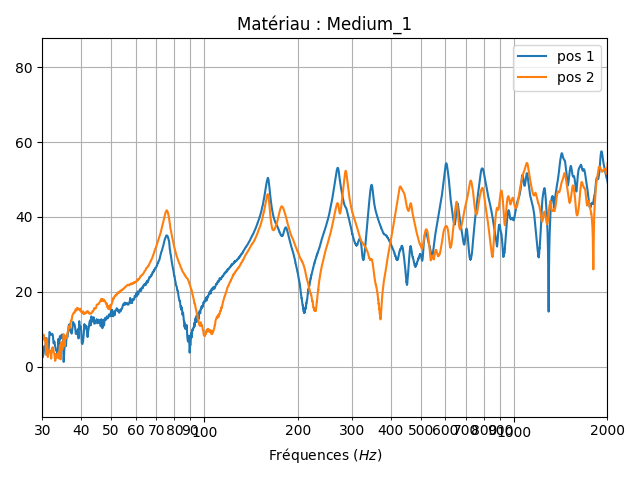

In [5]:
plot_frfs_mat(idx_mat)

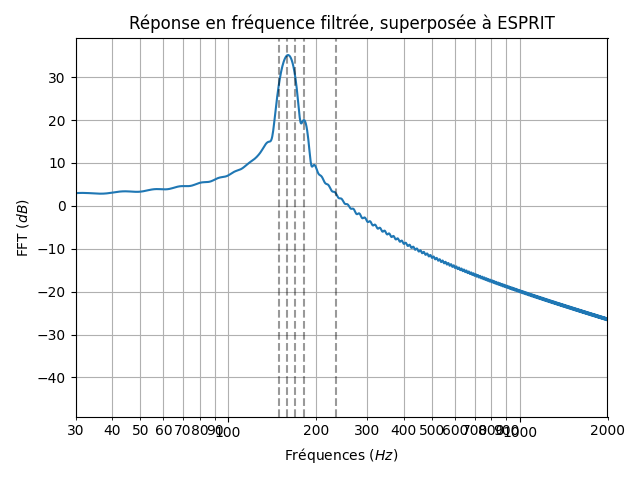

In [24]:
fk, deltak = esprit_on_band(dico_pos1["RI"], dico_pos1["fs"], 150, 180, 10, order=200, plot_result=True, len_esprit=4096, number_of_max=10)
# print(f
# print(deltak)

In [25]:
fk


array([158.8115816 , 169.17251662, 149.32031988, 181.8907475 ,
       233.97944613])

In [27]:
deltak

array([-4.97817176e-06, -4.46128821e-04, -1.78929982e-04, -2.99403632e-04,
       -3.30158405e-04])

In [47]:
import pandas as pd

modal_analysis = {
    #"table" : dico_pos1["mat_table"],
    "freq_metal" : np.array([173,345,378,506,606,711,776,842,889,967,1049,1097,1184]),
    "freq_plexi" : np.array([72.09741278, 142.14215793, 156.59010082, 236.7269505, 248.2530023, 294.94358678, 337.50039829, 402.02166775, 444.4563055, 480, 496.89932282, 545.17710008, 561.25346576]),
    "freq_medium_1" : np.array([75,149,160,182,270,286,319,345,427,460,522,602,654]),
    "freq_medium_2" : np.array([106.97717034, 164.90739819, 189.34747316, 265.9351928, 413.26057931, 425.57839152, 460.04801994, 533.50668071, 604.37383295, 694.37280608, 759.73928757, 817.61882733, 870.98284749])

   # "xi" : np.array([-0.00020138, -0.00021048, -4.5004e-4, -0.00035561, -0.00039229, -1.52620143e-04, -0.00050664, -0.00031898, -0.00036209, -0.00027529, -0.00058368, -0.00082278, -0.00075488]),
}

modal_analysis["ratios_metal"] = modal_analysis["freq_metal"] / modal_analysis["freq_metal"][0]
modal_analysis["ratios_plexi"] = modal_analysis["freq_plexi"] / modal_analysis["freq_plexi"][0]
modal_analysis["ratios_medium_1"] = modal_analysis["freq_medium_1"] / modal_analysis["freq_medium_1"][0]
modal_analysis["ratios_medium_2"] = modal_analysis["freq_medium_2"] / modal_analysis["freq_medium_2"][0]
df_modal_analysis = pd.DataFrame(modal_analysis).T
df_modal_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12
freq_metal,173.000000,345.000000,378.000000,506.000000,606.000000,711.000000,776.000000,842.000000,889.000000,967.000000,1049.000000,1097.000000,1184.000000
freq_plexi,72.097413,142.142158,156.590101,236.726950,248.253002,294.943587,337.500398,402.021668,444.456305,480.000000,496.899323,545.177100,561.253466
freq_medium_1,75.000000,149.000000,160.000000,182.000000,270.000000,286.000000,319.000000,345.000000,427.000000,460.000000,522.000000,602.000000,654.000000
freq_medium_2,106.977170,164.907398,189.347473,265.935193,413.260579,425.578392,460.048020,533.506681,604.373833,694.372806,759.739288,817.618827,870.982847
ratios_metal,1.000000,1.994220,2.184971,2.924855,3.502890,4.109827,4.485549,4.867052,5.138728,5.589595,6.063584,6.341040,6.843931
ratios_plexi,1.000000,1.971529,2.171924,3.283432,3.443300,4.090904,4.681172,5.576090,6.164664,6.657659,6.892055,7.561674,7.784655
ratios_medium_1,1.000000,1.986667,2.133333,2.426667,3.600000,3.813333,4.253333,4.600000,5.693333,6.133333,6.960000,8.026667,8.720000
ratios_medium_2,1.000000,1.541520,1.769980,2.485906,3.863073,3.978217,4.300432,4.987108,5.649559,6.490850,7.101882,7.642928,8.141764


In [35]:
data_dict

/var/folders/k2/m05vfpwn0qn71pjn0jnlb0l80000gn/T/ipykernel_33127/3305447764.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,3))


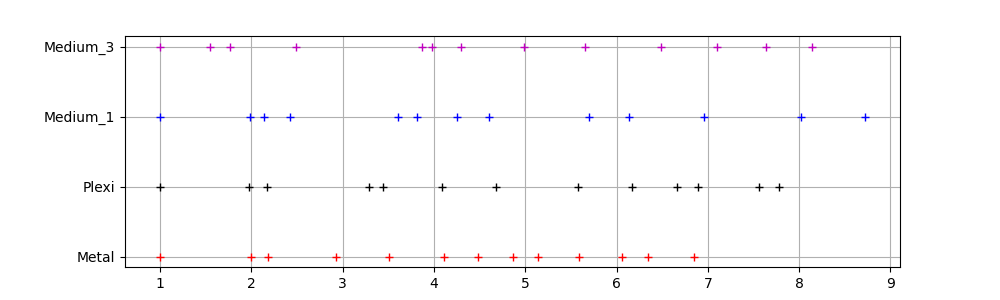

In [49]:
plt.figure(figsize=(10,3))
plt.plot( modal_analysis["ratios_metal"],[0]*13,'r+')
plt.plot(modal_analysis["ratios_plexi"],[1]*13,'k+')
plt.plot(modal_analysis["ratios_medium_1"],[2]*13,'b+')
plt.plot(modal_analysis["ratios_medium_2"],[3]*13,'m+')
plt.yticks([0,1,2,3],['Metal','Plexi','Medium_1','Medium_2'])
plt.grid()
plt.show()